1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


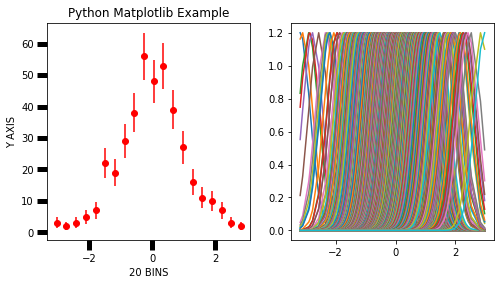

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

mean=0
std_dev=1
x=np.random.normal(mean,std_dev,400)
x=np.sort(x)
#x = np.random.normal(0, 1, 200)
#x = np.sort(x)
#a = x.reshape(50,4)
df = pd.DataFrame(x)
df
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))

ax1.set_title('Python Matplotlib Example')
ax1.set_ylabel('Y AXIS')
ax1.set_xlabel('20 BINS')
ax1.tick_params(which='major', width=5.0)
ax1.tick_params(which='major', length=10)
counts,bins = np.histogram(x,20)
bin_centres = (bins[:-1]+((bins[1]-bins[0])/2))
err = pow(counts,1/2)
ax1.errorbar(bin_centres, counts, yerr=err, fmt='or')

from scipy import stats
gaussians = []
b = 1.06 * x.std() * (x.size ** (-1/5))
#print(b)
for i in x:    
    c = stats.norm.pdf(x, i , b)
    gaussians.append(c)

#print(gaussians)
import seaborn as sns
for i in gaussians:
    ax2.plot(x, i, '-')


In [26]:
v = np.sum(gaussians, axis = 0)

-1.084980146560504
gint 397.68883736099605
norm -366.5401976448229
-3.4193436436043783
44105.12231370276


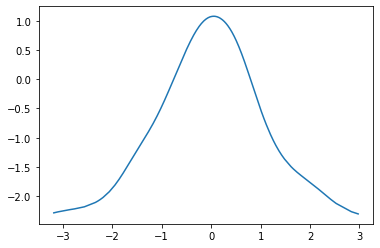

In [45]:
import scipy
from sklearn.preprocessing import MinMaxScaler

#normalization
#histogram
h_int=np.sum(x*((bins[1]-bins[0])))
print(h_int)
#gaussian
g_int=scipy.integrate.trapz(v,x)
print('gint', g_int)
norm_fatt=g_int/h_int
print("norm", norm_fatt)

#plt.plot(x,v)

print(scipy.integrate.trapz(x))
print(scipy.integrate.trapz(v))

v_norm = []
for i in v:
    a = (i-v.mean())/(v.std())
    v_norm.append(a)
plt.plot(x, v_stand)    


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

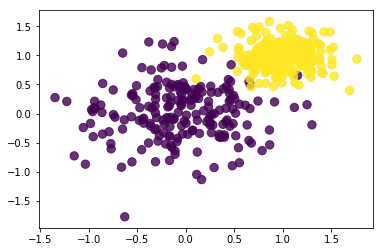

In [3]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [198]:
def twodee_datasets(n):
    df = pd.DataFrame()
    for n in range(2*n):
        X1 = np.random.normal(0,1,50)
        df.insert(0, "values", X1, True) 
        n+=1
    #df.columns["x1", "x2", "x3", "x4"]
    return df

In [199]:
twodee_datasets(2)

,values,values,values,values
0,-1.812941,0.628405,0.768413,-0.404898
1,0.639891,-0.254845,0.259819,-1.017562
2,2.517357,-0.847035,-0.040694,-0.761199
3,0.125919,-0.328606,1.962313,-0.799666
4,0.637778,0.622093,0.156174,-0.830330
5,2.604792,1.520385,0.386370,-0.957219
6,-1.569008,0.890272,0.290846,-0.042299
7,0.276376,0.661298,0.284445,-0.524422
8,0.045778,0.349942,-0.392113,-0.360721
9,0.458786,-1.716499,0.571785,1.249185


In [183]:
#X1, X2 = twodee_datasets(2)
X1 = np.random.normal(0,1,150)
X2 = np.random.normal(1,0.8,150)
lst = np.c_[X1, X2]
df = pd.DataFrame(lst, columns = ['X1', 'X2'])
X3 = np.random.normal(2,0.5,150)
X4 = np.random.normal(3,1,150)
df['X3'] = X3
df['X4'] = X4
df

,X1,X2,X3,X4
0,0.792612,1.613428,1.597791,3.000104
1,-0.912602,1.488941,2.611651,1.918072
2,0.197833,-0.093908,1.206222,2.837487
3,-0.223255,0.757638,2.545422,3.944858
4,-1.100287,2.385931,2.132992,1.071535
...,...,...,...,...
145,0.524120,0.630986,1.561018,2.474583
146,-0.199121,1.829002,2.226810,3.935524
147,1.337905,0.355681,1.331097,2.091335
148,-0.693384,0.145677,2.782299,2.036128


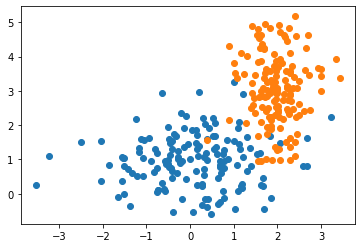

In [5]:
plt.scatter(X1, X2)
plt.scatter(X3, X4)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [6]:
!curl https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


In [7]:
A = np.load('residuals_261.npy', allow_pickle=True)
print(A)
b = A.item()
print(b)
df=pd.DataFrame(b)
df

{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])}
{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])}


,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [8]:
df_new = df[df['residuals'] < 2]
df_new2 = df_new[df_new['residuals'] > -2]
df_new2

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [9]:
residuals = df_new2['residuals'].tolist()
distances = df_new2['distances'].tolist()
scipy.stats.linregress(residuals, distances)

NameError: name 'scipy' is not defined

In [10]:
import seaborn as sns
sns.set(style="darkgrid")

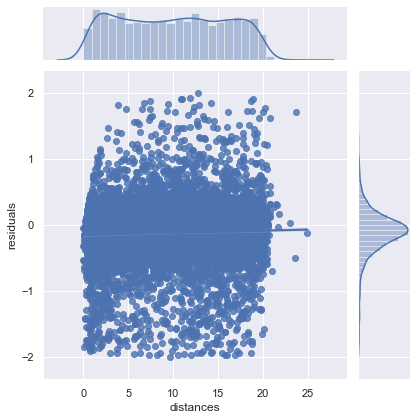

In [11]:
sns.jointplot(x="distances", y="residuals", data=df_new2, kind='reg');


In [12]:
# Fill 3 numpy arrays
# x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
# y, the mean values of the "residuals", estimated in slices (bins) of "distance"
# erry, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
# Plot the profile plot on top of the scatter plot

In [13]:
x = np.array(distances)
x

array([16. ,  6.3,  3.3, ...,  1.7, 19.1,  2.6])